Found 1828 images belonging to 8 classes.
Found 457 images belonging to 8 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training the top layers...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 774s 13s/step - accuracy: 0.4504 - loss: 1.6986 - val_accuracy: 0.7374 - val_loss: 1.1293 - learning_rate: 1.0000e-04
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 660s 11s/step - accuracy: 0.8435 - loss: 0.4604 - val_accuracy: 0.8709 - val_loss: 0.7188 - learning_rate: 1.0000e-04
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 656s 11s/step - accuracy: 0.8728 - loss: 0.3810 - val_accuracy: 0.8972 - val_loss: 0.4903 - learning_rate: 1.0000e-04
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 668s 12s/step - accuracy: 0.9217 - loss: 0.2182 - val_accuracy: 0.8950 - val_loss: 0.3711 - learning_rate: 1.0000e-04
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 670s 11s/step - accuracy: 0.9342 - loss: 0.1954 - val_accuracy: 0.9059 - val_loss: 0.2872 - learning_rate: 1.0000e-04
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 667s 11s/step - accuracy: 0.9537 - loss: 0.1385 - val_accuracy: 0.9365 - val_loss: 0.2430 - learning_rate: 1.0000e-04
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 654s 11s/step - accuracy: 

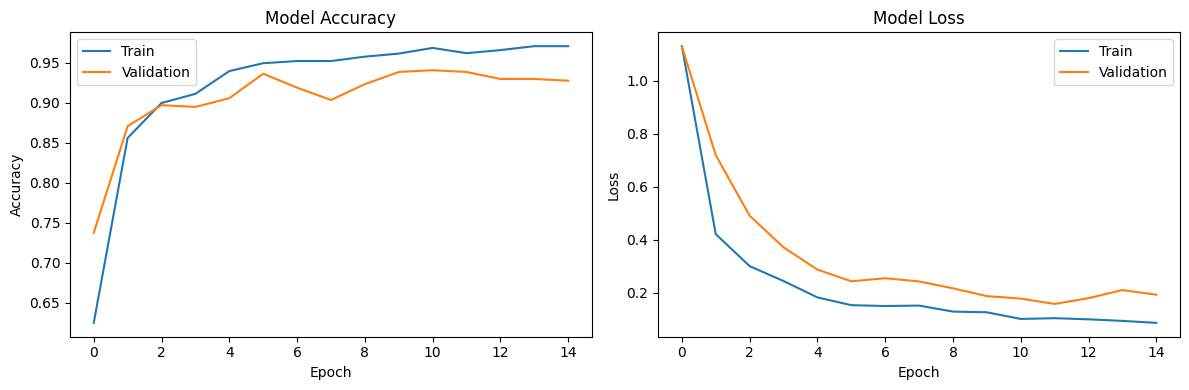

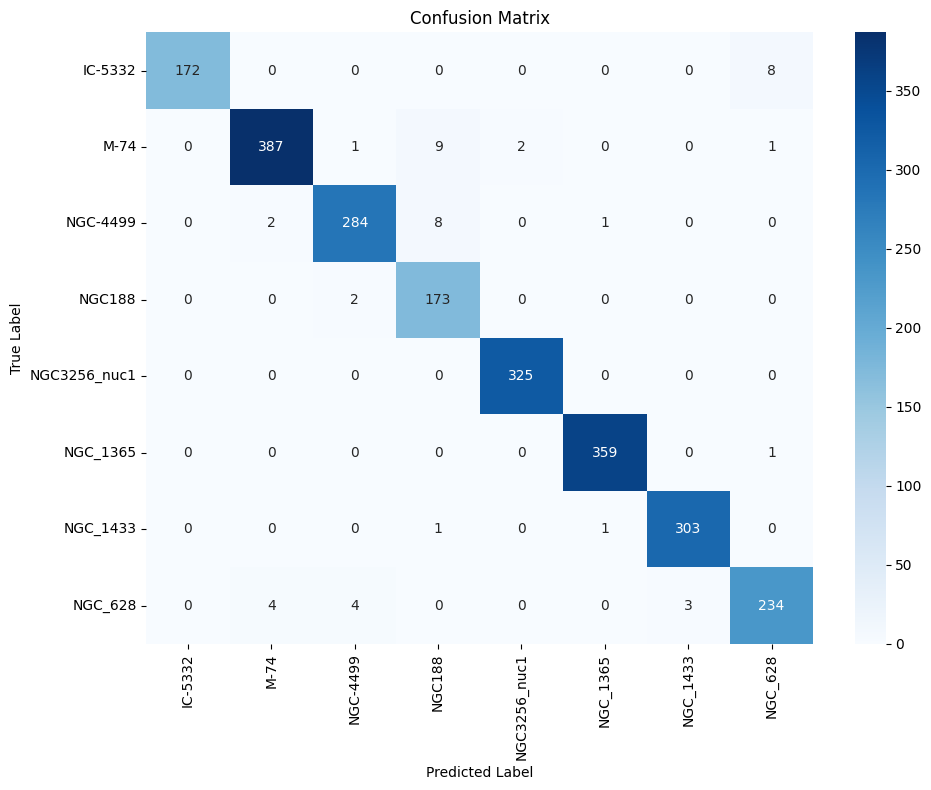

In [3]:
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)
import tensorflow as tf

# Configuration
IMG_SIZE = 299  # InceptionV3 recommended input size
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0001

def create_model(num_classes):
    """Create InceptionV3-based model with fine-tuning"""

    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze the base model layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

def setup_data_generators():
    """Set up data generators with improved augmentation."""

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def plot_training_history(history):
    """Plot training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def main():
    # Set up data paths
    data_dir = '/content/drive/MyDrive/Ml-project/Project-Review-3 /Dataset'  # Update with your path

    # Set up data generators
    train_datagen, test_datagen = setup_data_generators()

    # Load and prepare the data
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    num_classes = len(train_generator.class_indices)

    # Create and compile the model
    model, base_model = create_model(num_classes)

    # Callbacks
    callbacks = [
        ModelCheckpoint(
            '/content/drive/MyDrive/Ml-project/Project-Review-3/inceptionv3_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ]

    print("Training the top layers...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    print("Fine-tuning the model...")
    # Unfreeze top 30% of layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[int(total_layers * 0.7):]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE/10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_fine = model.fit(
        train_generator,
        epochs=EPOCHS//2,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    print("Evaluating the model...")
    test_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    plot_training_history(history)
    plot_confusion_matrix(y_true, y_pred, class_names)

if __name__ == "__main__":
    main()


In [2]:
# prompt: genrte a code to connect to drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
